# Aggregate Data Visualisation

## Initalisation

In [1]:
import os 
import pylab
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
newspapers = ['times_of_malta','the_shift','malta_today','independent','malta_daily','gozo_news']

news_df = [pd.read_csv(os.path.join('..','data_collection',n,'final_data.csv'),
                       index_col=False) for n in newspapers]

for n in news_df: 
    if 'Caption' not in n.columns: n[['BLIP Caption x NER Caption',
                                      'ITM x NER Caption',
                                      'ITC x NER Caption']] = 0

## Create aggregate dataframe with mean values from all newspapers

In [3]:
#Create aggregate dataframe
columns=['BLIP Caption x NER Title','ITM x NER Title','ITC x NER Title',
         'BLIP Caption x NER Caption','ITM x NER Caption','ITC x NER Caption',
         'BLIP Caption x KW Body','ITM x KW Body','ITC x KW Body']

#Take average values ignoring zeroes
df =  pd.DataFrame(newspapers,columns=['Newspaper']).join(
         pd.DataFrame([n[columns][n[columns]!=0].mean() for n in news_df], columns=columns))

df['Newspaper'] = ['Times of Malta','The Shift','Malta Today','Malta Independent','Malta Daily','Gozo News']
df.to_csv(os.path.join('..','agg_data.csv'), index=False)

for c in ['BLIP Caption x NER Caption','ITM x NER Caption','ITC x NER Caption']:
    df[c] = df[c].apply(lambda x: 0 if np.isnan(x) else x)
    
l = len(df)
df.to_csv('aggregate.csv', index=False)
df

,Newspaper,BLIP Caption x NER Title,ITM x NER Title,ITC x NER Title,BLIP Caption x NER Caption,ITM x NER Caption,ITC x NER Caption,BLIP Caption x KW Body,ITM x KW Body,ITC x KW Body
0,Times of Malta,0.138355,0.289038,0.289981,0.222714,0.257113,0.260153,0.118768,0.306486,0.293973
1,The Shift,0.087769,0.211533,0.260754,0.104879,0.161945,0.194736,0.070922,0.239818,0.274122
2,Malta Today,0.108330,0.239205,0.270552,0.134746,0.114050,0.210576,0.084069,0.232126,0.272275
3,Malta Independent,0.116128,0.344140,0.302463,0.000000,0.000000,0.000000,0.096870,0.377224,0.311212
4,Malta Daily,0.166800,0.387067,0.320884,0.000000,0.000000,0.000000,0.118591,0.453707,0.337450
5,Gozo News,0.145861,0.361346,0.305931,0.000000,0.000000,0.000000,0.127788,0.425507,0.322117


## <code>get_palette</code>

In [4]:
def get_palette(values, neutral=False, switch=False):
    
    if neutral:
#         p_palette = np.array(sns.diverging_palette(58,68,s=100000,n=l*2,center='light'))[:l]
        p_palette = sns.color_palette('flare',n_colors=l*2)[:l]
        n_palette = sns.color_palette('flare',n_colors=l*2)[l:]
    else:
        p_palette = np.array(sns.diverging_palette(120, 140,s=1000,n=l*2,center='light'))[:l]
        n_palette = np.array(sns.diverging_palette(0, 20,s=1000,n=l*2,center='light'))[:l]
        
    palette   = np.array([[0.]*3]*l)
    
    #Let higher values be red instead of green
    if switch:
        p_palette,n_palette = n_palette,p_palette
    
    
    v   = np.sort(values.iloc[0]) #List of values
    idx = np.argsort(values.iloc[0].tolist()) #Indices of sorted v
    
    #Determine index where elements of v cross 0
    k=0
    while v[k]<=0: 
        k+=1 
    
    #Trim short palette list and reverse
    p_palette = p_palette[::-1][k:]
    
        
    p,n = 0,0
    
    #Assign brightest possible red/green color for corresponding -ve/+ve values
    for i,j in enumerate(idx):
        if i < k:
            palette[j] = n_palette[n]
            n+=1
        else:
            palette[j] = p_palette[p]
            p+=1

    return sns.color_palette(palette)
    

## <code>draw_maxdiff</code>

In [40]:
def draw_maxdiff(key:str,xlabel:str,title:str,switch:bool=False,neutral:bool=False,caption:bool=False):

    sns.set(rc={'figure.figsize':(28,18)})
    sns.set(font="JetBrains Mono")
    plt.clf()

    val = df[['Newspaper',key]]
        
    #Drop non-caption newspapers
    if caption: val = val[val[key] != 0]
        
    #Calculate average
    mean = val[key].mean()

    #Get maxdiff values
    val[key] = val[key].apply(lambda x: x-mean)
    val = val.set_index('Newspaper').T

    # val.to_csv('test.csv',index=False)

    #Plot Barplot
    palette = np.array(sns.diverging_palette(0, 120,s=1000,n=len(val.columns),center='light'))[val.iloc[0].rank().sub(1).astype(int).array]
    palette = get_palette(val,neutral,switch)
    
    ax = sns.barplot(data=val,orient='h',estimator=lambda x: (float(x)/mean)*100,
                     palette=palette)
    
    #Percentage offset between gridlines
    p = 20 
    q = p/100
    
    ax.set_xticks(range(-100,100+p,p))
    ax.set_xticklabels([str(i)+'%' for i in range(-100,100+p,p)])
    ax.tick_params(labelsize=24)
    ax.set_xlabel(f'\n\n{xlabel}', fontsize=40)
    ax.set_ylabel(f'Newspaper', fontsize=40)
    ax.yaxis.set_label_coords(-0.2,0.5)
    ax.axvline(0)
    
    #Add another axis
    ax2 = ax.twiny()
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("axes", -0.05))
    ax2.tick_params(axis='x', colors='grey')
    ax2.tick_params(labelsize=20)
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    ax2.grid(False)
    
    num_ticks = 11 #Number of ticks on second x-axis
    #Cant find a way to calculate the offset (0.099..) from num_ticks. 1/num_ticks does compresses axis
    ax2.set_xticks(np.arange(0,1,0.0999999999)) 
    t = 0.5/(num_ticks//2)
    ax2.set_xticklabels([round(mean-i*mean,4) for i in np.arange(1,0,-q)] +
                        [f'{round(mean,4)}\n(Mean)'] +
                        [round(mean+i*mean,4) for i in np.arange(q,1+q,q)])
    
    #Display Labels
    ax.bar_label(ax.containers[0], fmt='    %.2f  ', fontsize=28)
    ax.set_title(f'{title}\n',fontsize=40)
    
    #Save figure
    pylab.savefig(os.path.join('figures','maxdiff',f'{key} maxdiff.jpg'), bbox_inches='tight', pad_inches=1, dpi=300)

## <code>draw_barchart</code>

In [45]:
def draw_barchart(key:str,xlabel:str,title:str,switch:bool=False,neutral:bool=False,caption:bool=False):
    
    sns.set(rc={'figure.figsize':(28,18)})
    sns.set(font="JetBrains Mono")
    plt.clf()
    
    val = df[['Newspaper',key]]
    
    #Drop non-caption newspapers
    if caption: val = val[val[key] != 0]
    
    original = val[key].tolist()
    
    #Calculate average
    mean = val[key].mean()
    norm_val = val.copy()
    norm_val[key] = norm_val[key].apply(lambda x: x-mean)

    norm_val = norm_val.set_index('Newspaper').T
    val = val.set_index('Newspaper').T

    #Plot Barplot
    palette = np.array(sns.diverging_palette(0, 120,s=1000,n=len(val.columns),center='light'))[val.iloc[0].rank().sub(1).astype(int).array]
    palette = get_palette(norm_val,neutral,switch)

    
    ax = sns.barplot(data=val,orient='v',
                     estimator=lambda x: float(x)*100,
                     palette=palette)

    ax.tick_params(labelsize=28)
    ax.set_ylabel(f'\n{xlabel}', fontsize=40)
    ax.set_xlabel(f'Newspaper', fontsize=40)

    #Display Labels
    ax.bar_label(ax.containers[0], fmt='    %.2f  ', fontsize=28)
    ax.set_title(f'{title}\n',fontsize=40)
    ax.axhline(y=mean*100, linestyle='--') 
    ax.set_yticks(np.arange(0,110,10))
    
    #Save figure
    pylab.savefig(os.path.join('figures','barchart',f'{key} barchart.jpg'), bbox_inches=None, pad_inches=0, dpi=300)

## <code>Initialisation</code>

In [7]:
bar_data = [('BLIP Caption x NER Title',
             'Similarity Score (%)',
             'Similarity of synthetic newspaper captions to headlines'),
            ('ITM x NER Title',
             'Similarity Score (%)',
             'Similarity of newspaper images to headlines'),
            ('ITC x NER Title',
             'Cosine Similarity Score (%)',
             'Cosine Similarity of newspaper images to headlines'),
            ('BLIP Caption x NER Caption',
             'Similarity Score (%)',
             'Similarity of synthetic newspaper captions to actual captions'),
            ('ITM x NER Caption',
             'Similarity Score (%)',
             'Similarity of newspaper images to their captions'),
            ('ITC x NER Caption',
             'Cosine Similarity Score (%)',
             'Cosine Similarity of newspaper images to their captions'),
            ('BLIP Caption x KW Body',
             'Similarity Score (%)',
             'Similarity of synthetic newspaper captions to condensed newspaper articles'),
            ('ITM x KW Body',
             'Similarity Score (%)',
             'Similarity of newspaper images to condensed newspaper articles'),
            ('ITC x KW Body',
             'Cosine Similarity Score (%)',
             'Cosine Similarity of newspaper images to headlines')]

hist_data = ['BLIP Caption x NER Title','ITM x NER Title','BLIP Caption x NER Caption',
             'ITM x NER Caption','BLIP Caption x KW Body','ITM x KW Body']

## Maxdiff graph

In [8]:
sns.set(rc={'figure.figsize':(28,18)})
sns.set(font="JetBrains Mono")

CPU times: total: 9.08 s
Wall time: 9.15 s


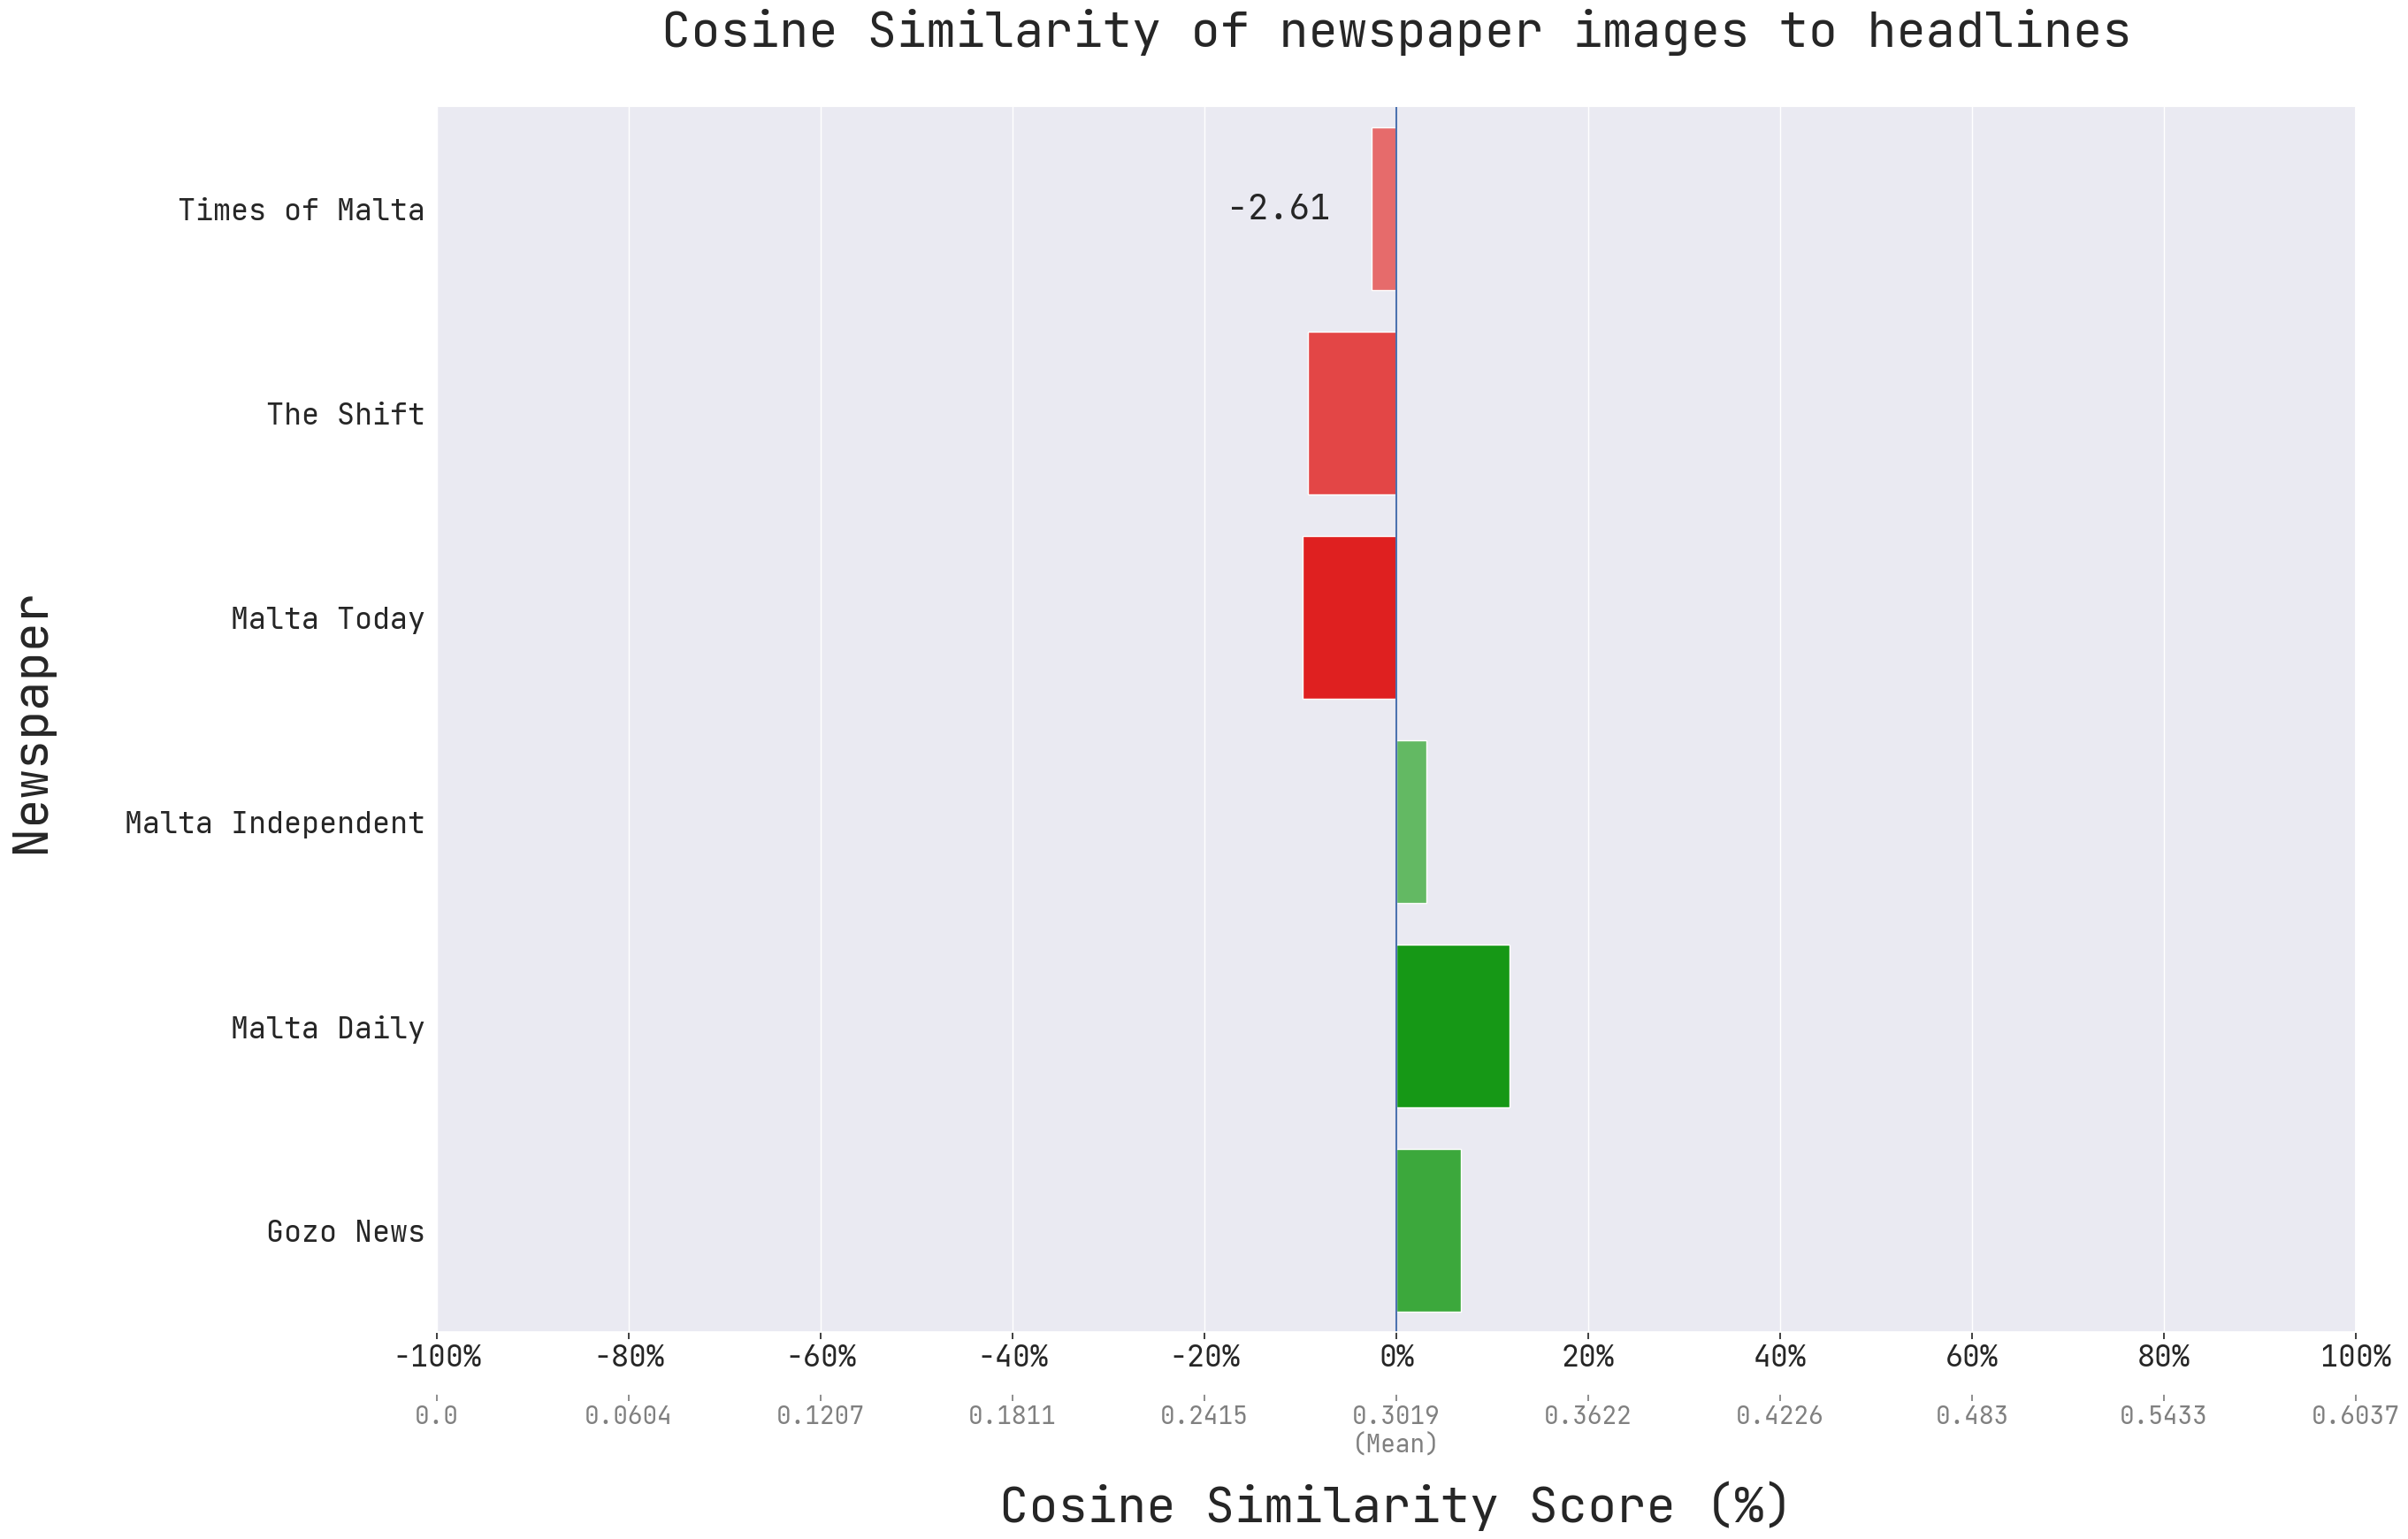

In [46]:
%%time
for key,xlabel,title in bar_data:
    draw_maxdiff(key,xlabel,title,
                 caption='Caption'  in key,
                 switch ='Negative' in key,
                 neutral='Neutral'  in key)


## Barchart

CPU times: total: 5.83 s
Wall time: 5.97 s


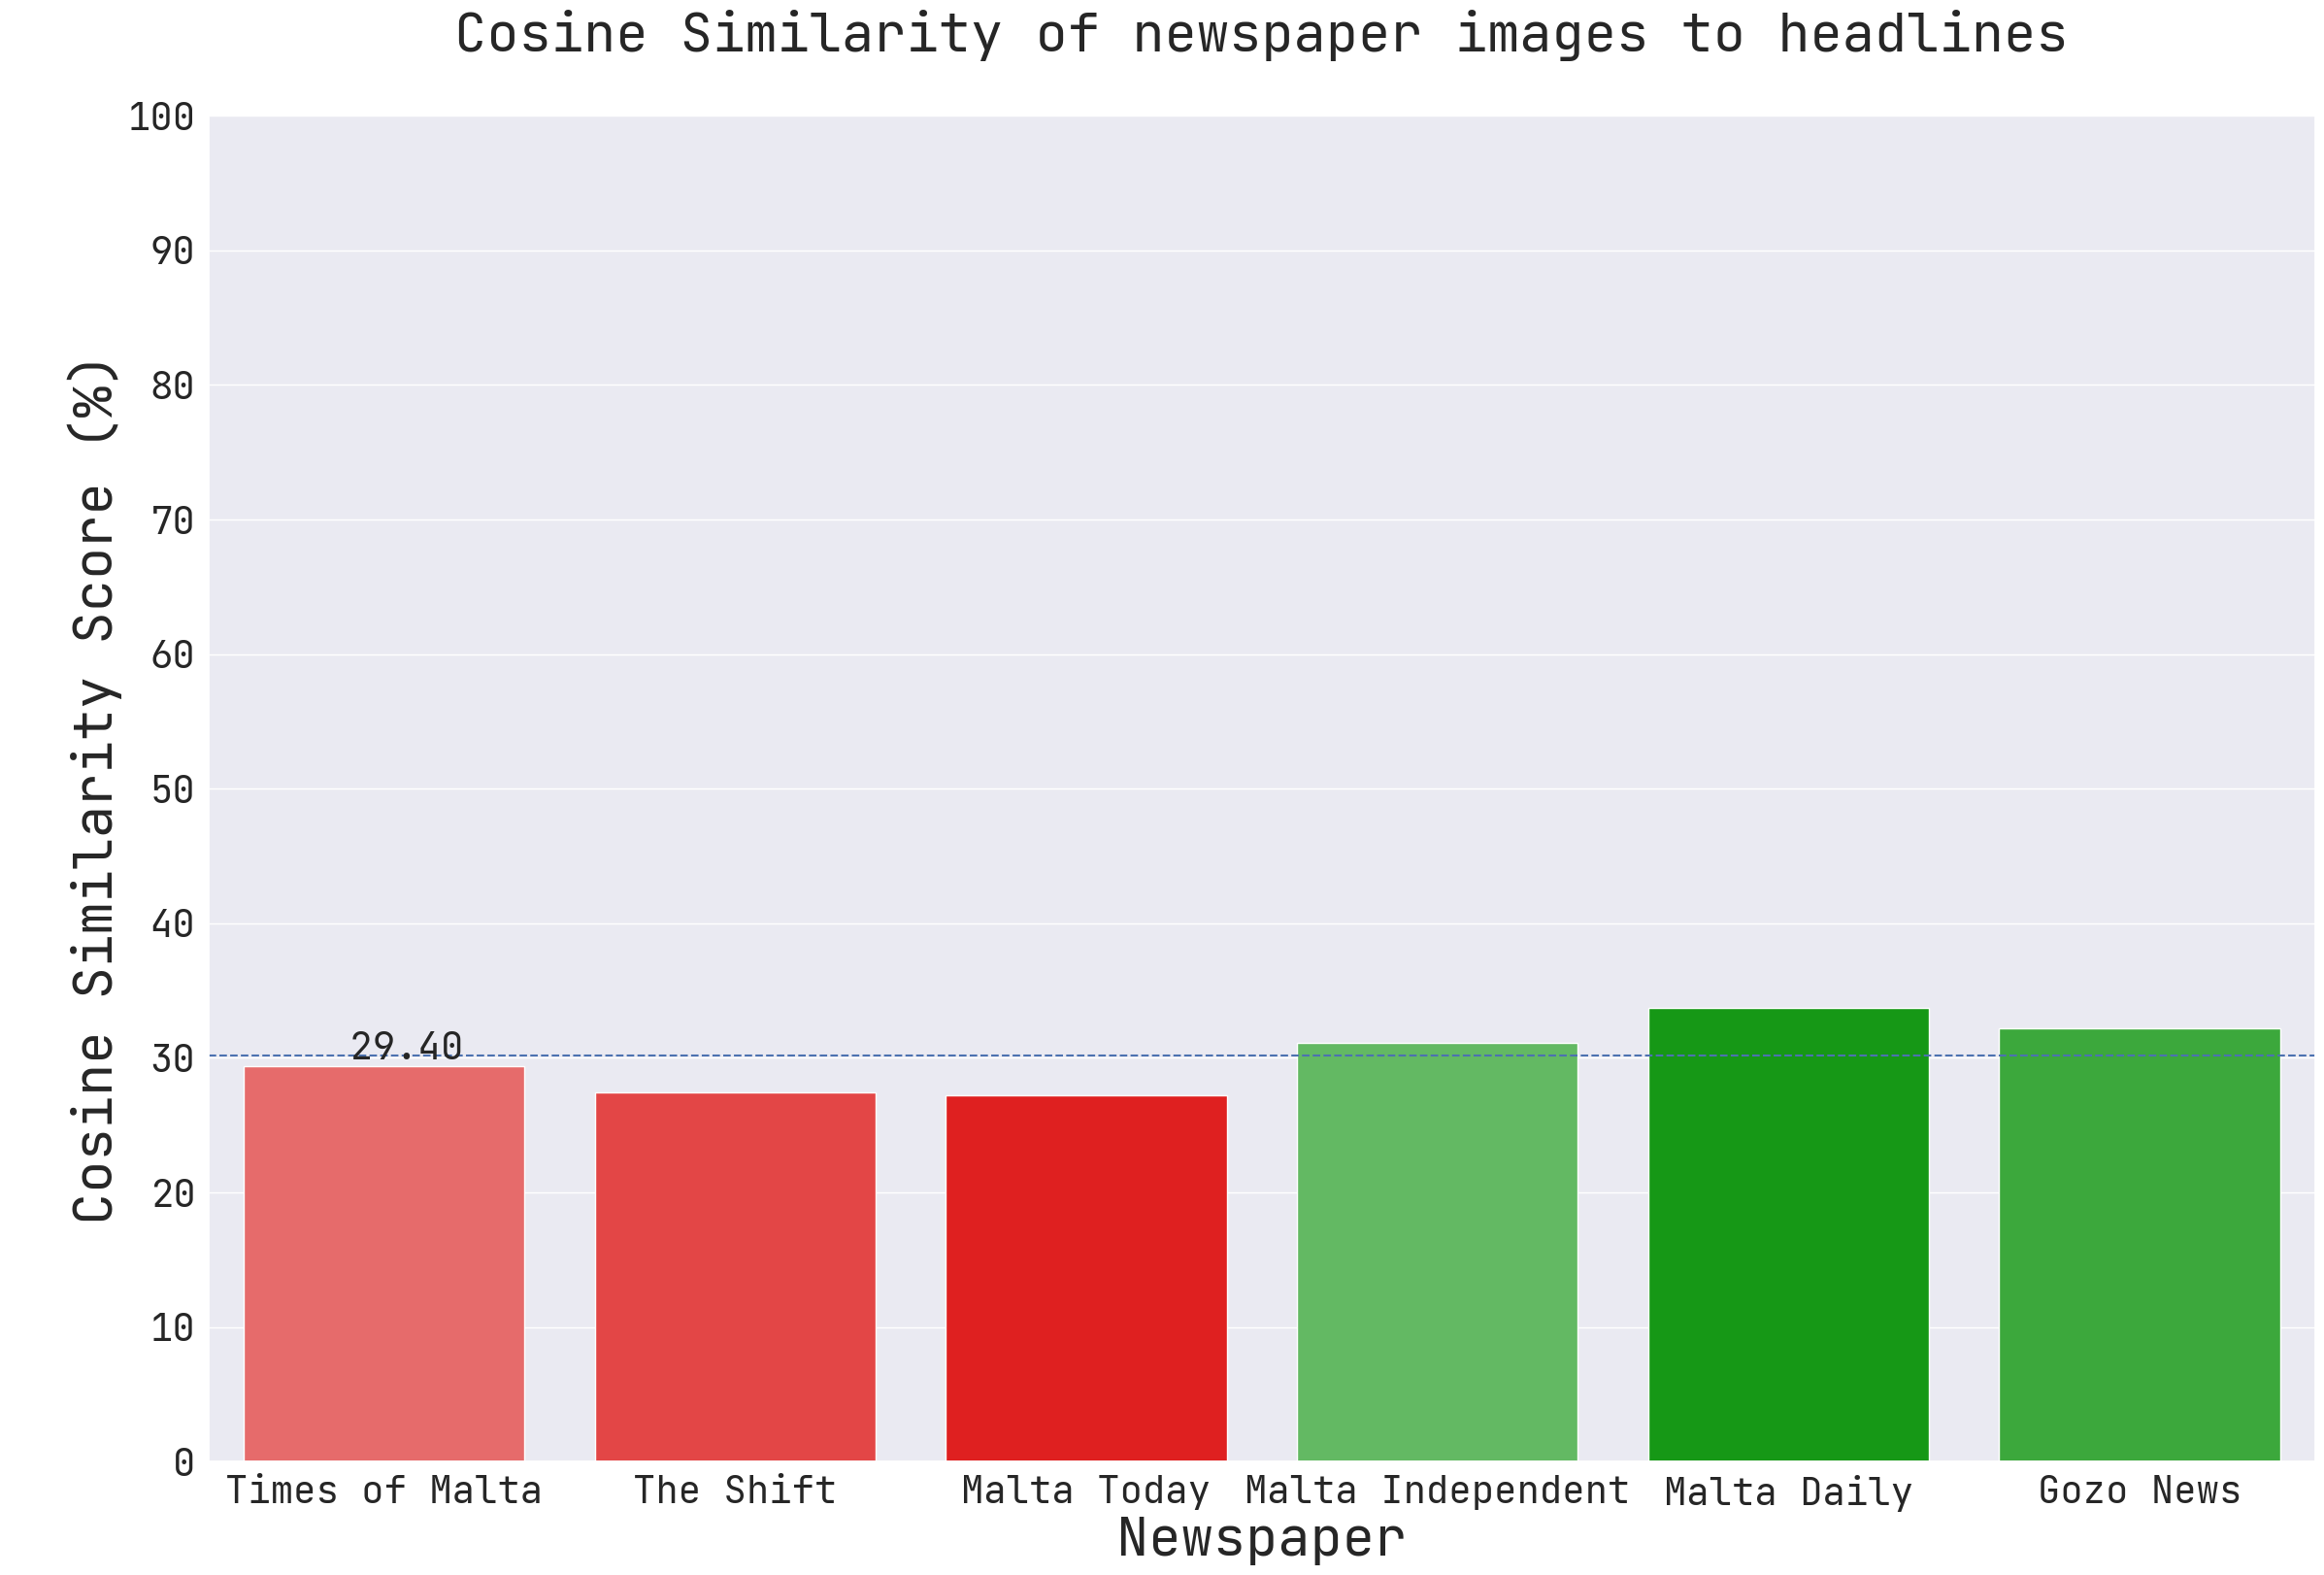

In [47]:
%%time
for key,xlabel,title in bar_data:
    draw_barchart(key,xlabel,title,
                 caption='Caption'  in key,
                 switch ='Negative' in key,
                 neutral='Neutral'  in key)

## Single Feature Sub Plots

CPU times: total: 9.8 s
Wall time: 9.81 s


''

<Figure size 2500x3000 with 0 Axes>

<Figure size 2500x3000 with 0 Axes>

<Figure size 2500x3000 with 0 Axes>

<Figure size 2500x3000 with 0 Axes>

<Figure size 2500x3000 with 0 Axes>

<Figure size 2500x3000 with 0 Axes>

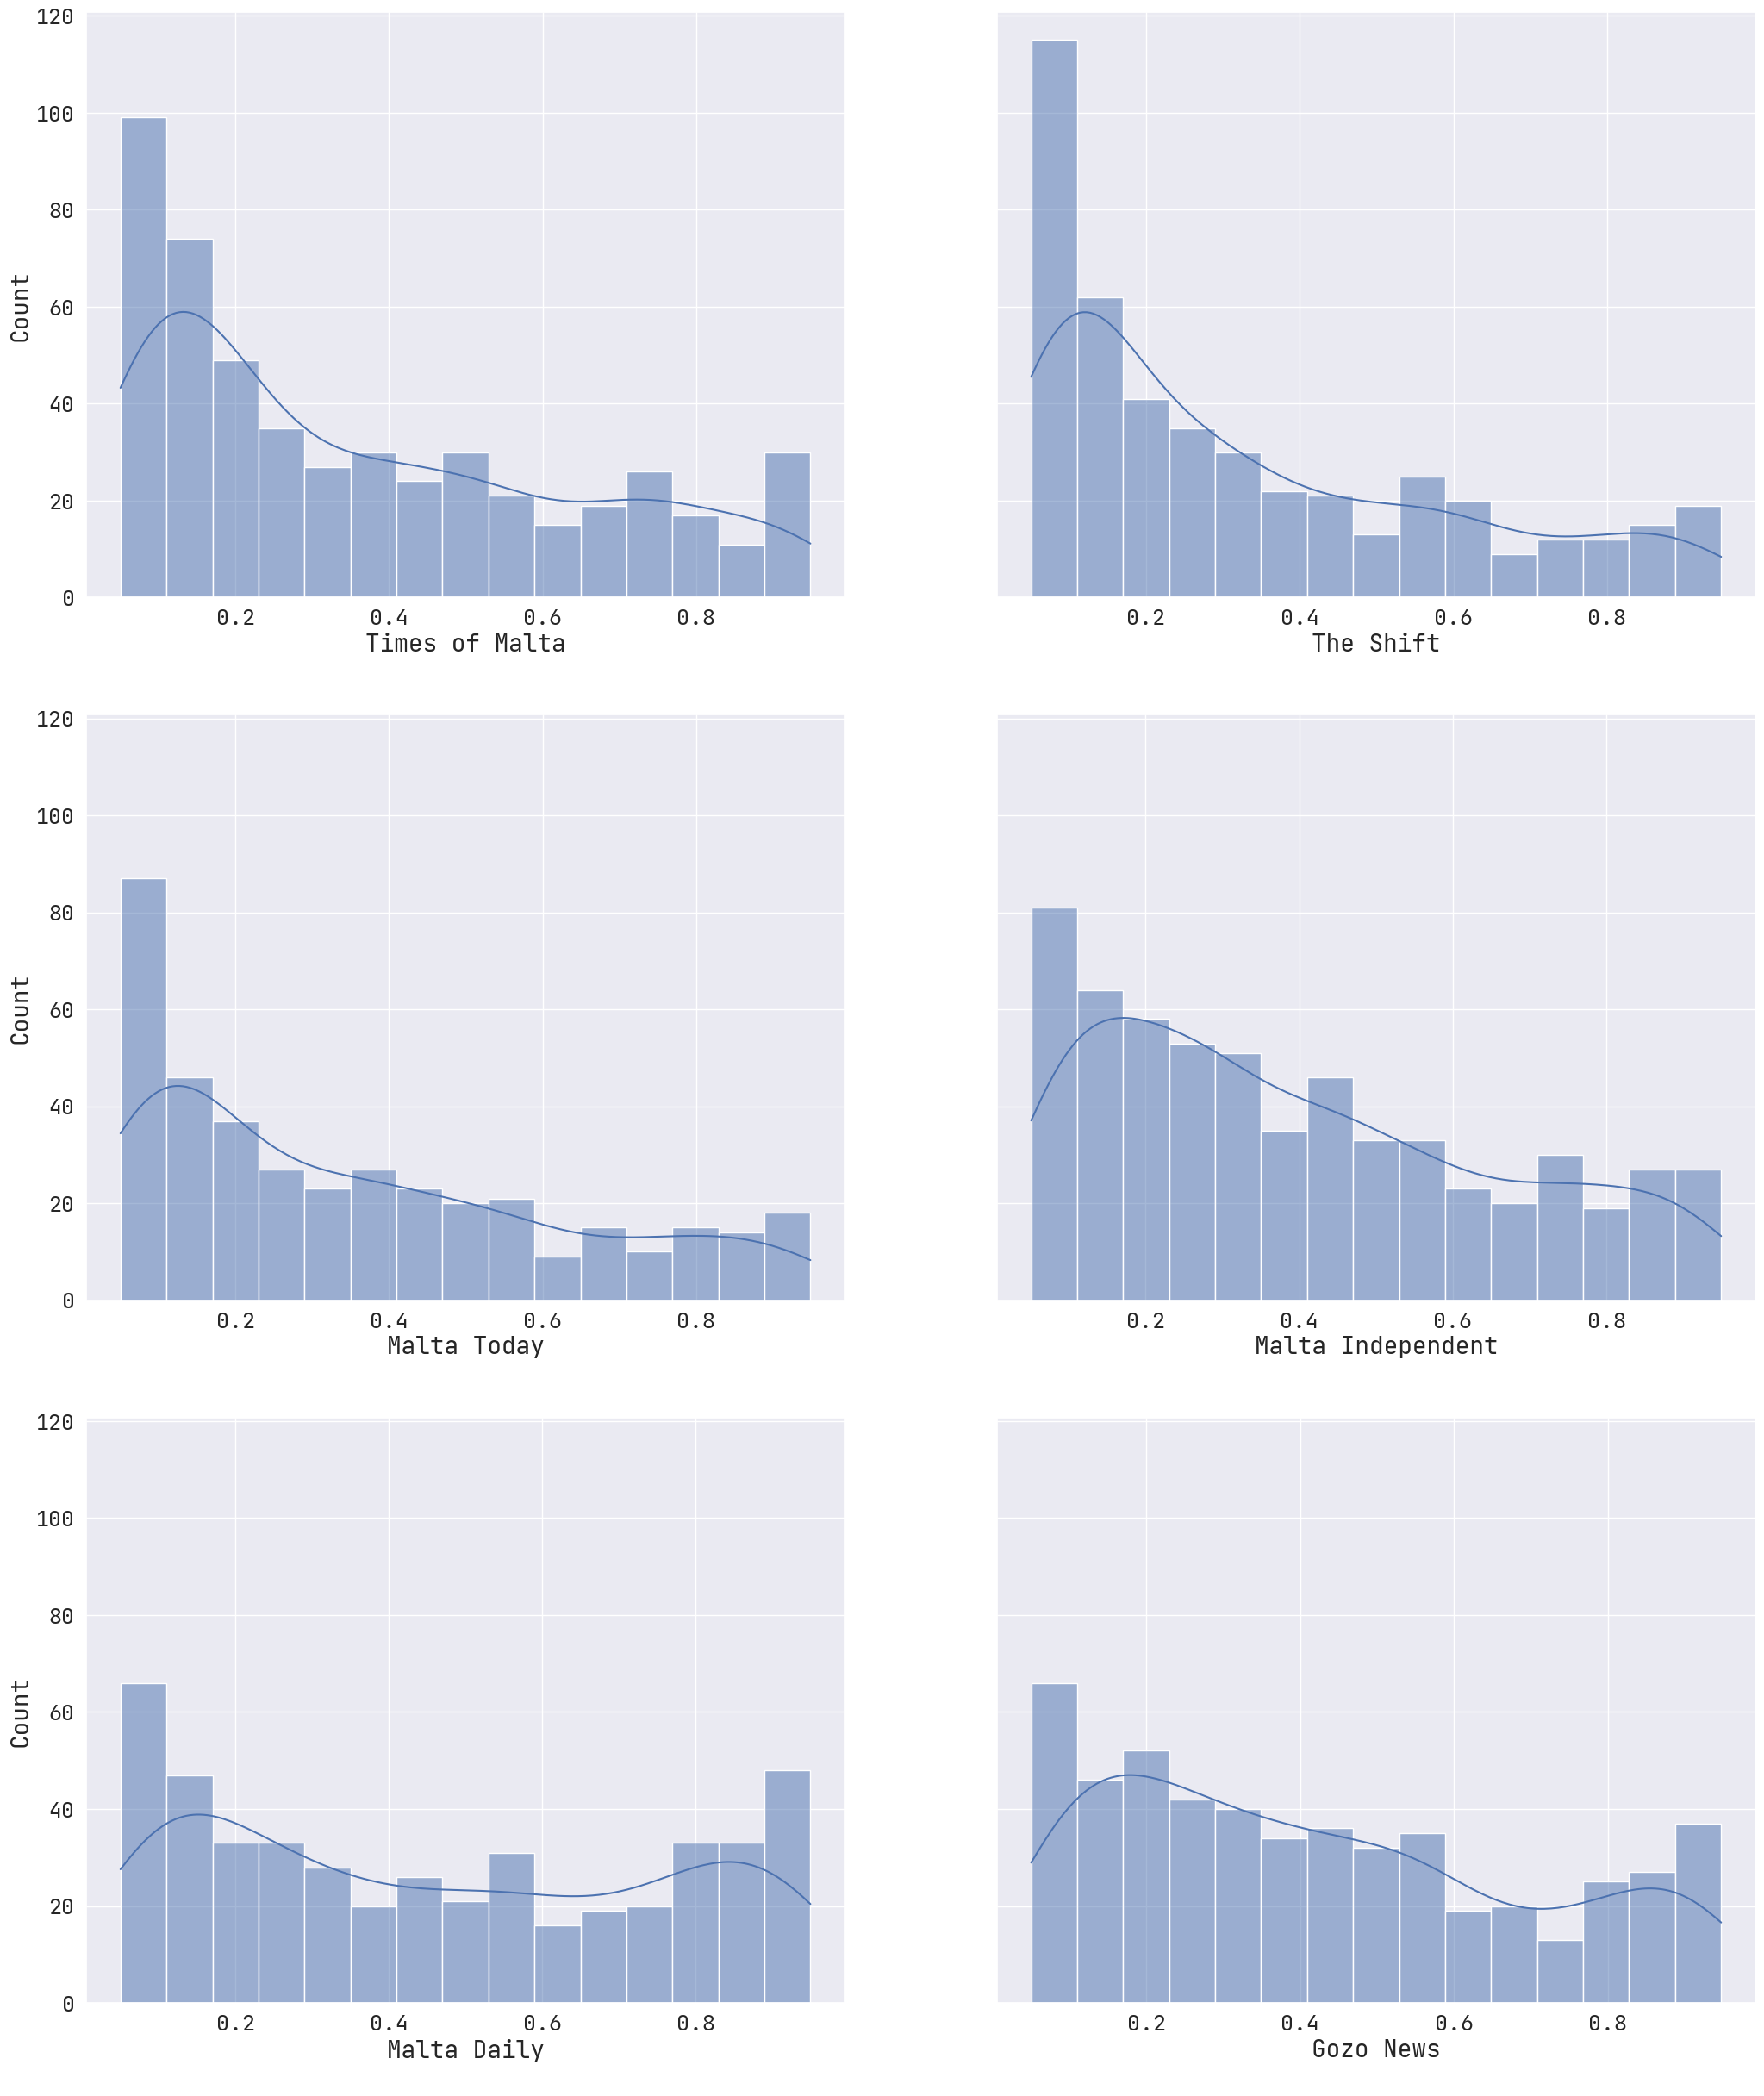

In [51]:
%%time

def draw_dist(key:str, xlabel:str,title:str):
    sns.set(rc={'figure.figsize':(25,30)})
    sns.set(font="JetBrains Mono")
    plt.clf()

#     key = 'ITM x KW Body'

    names = [['Times of Malta','The Shift'],
             ['Malta Today','Malta Independent'],
             ['Malta Daily','Gozo News']]

    fig,ax = plt.subplots(3, 2, sharey=True)
    fig.suptitle(title, fontsize=30)

    for (i,j),df in zip([(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)],news_df):

        df = df[df[key] > 0.05]
        df = df[df[key] < 0.95]

        ax[i][j] = sns.histplot(df[key],bins=15, kde=True,ax=ax[i][j])
        ax[i][j].tick_params(labelsize=18)
    #     ax[i][j].set_xticks(np.arange(0,1,0.1))
        ax[i][j].set_xlabel(f'{names[i][j]}\n{xlabel}', fontsize=20)
        ax[i][j].set_ylabel(f'Count', fontsize=20)
        
        #Save figure
    pylab.savefig(os.path.join('figures','dist',f'{key} single_subplots.jpg'),
                  bbox_inches=None, pad_inches=0, dpi=300)
    
    return

for key in hist_data:
    draw_dist(key,'','')
''

### Overlay multiple subplots into one

''

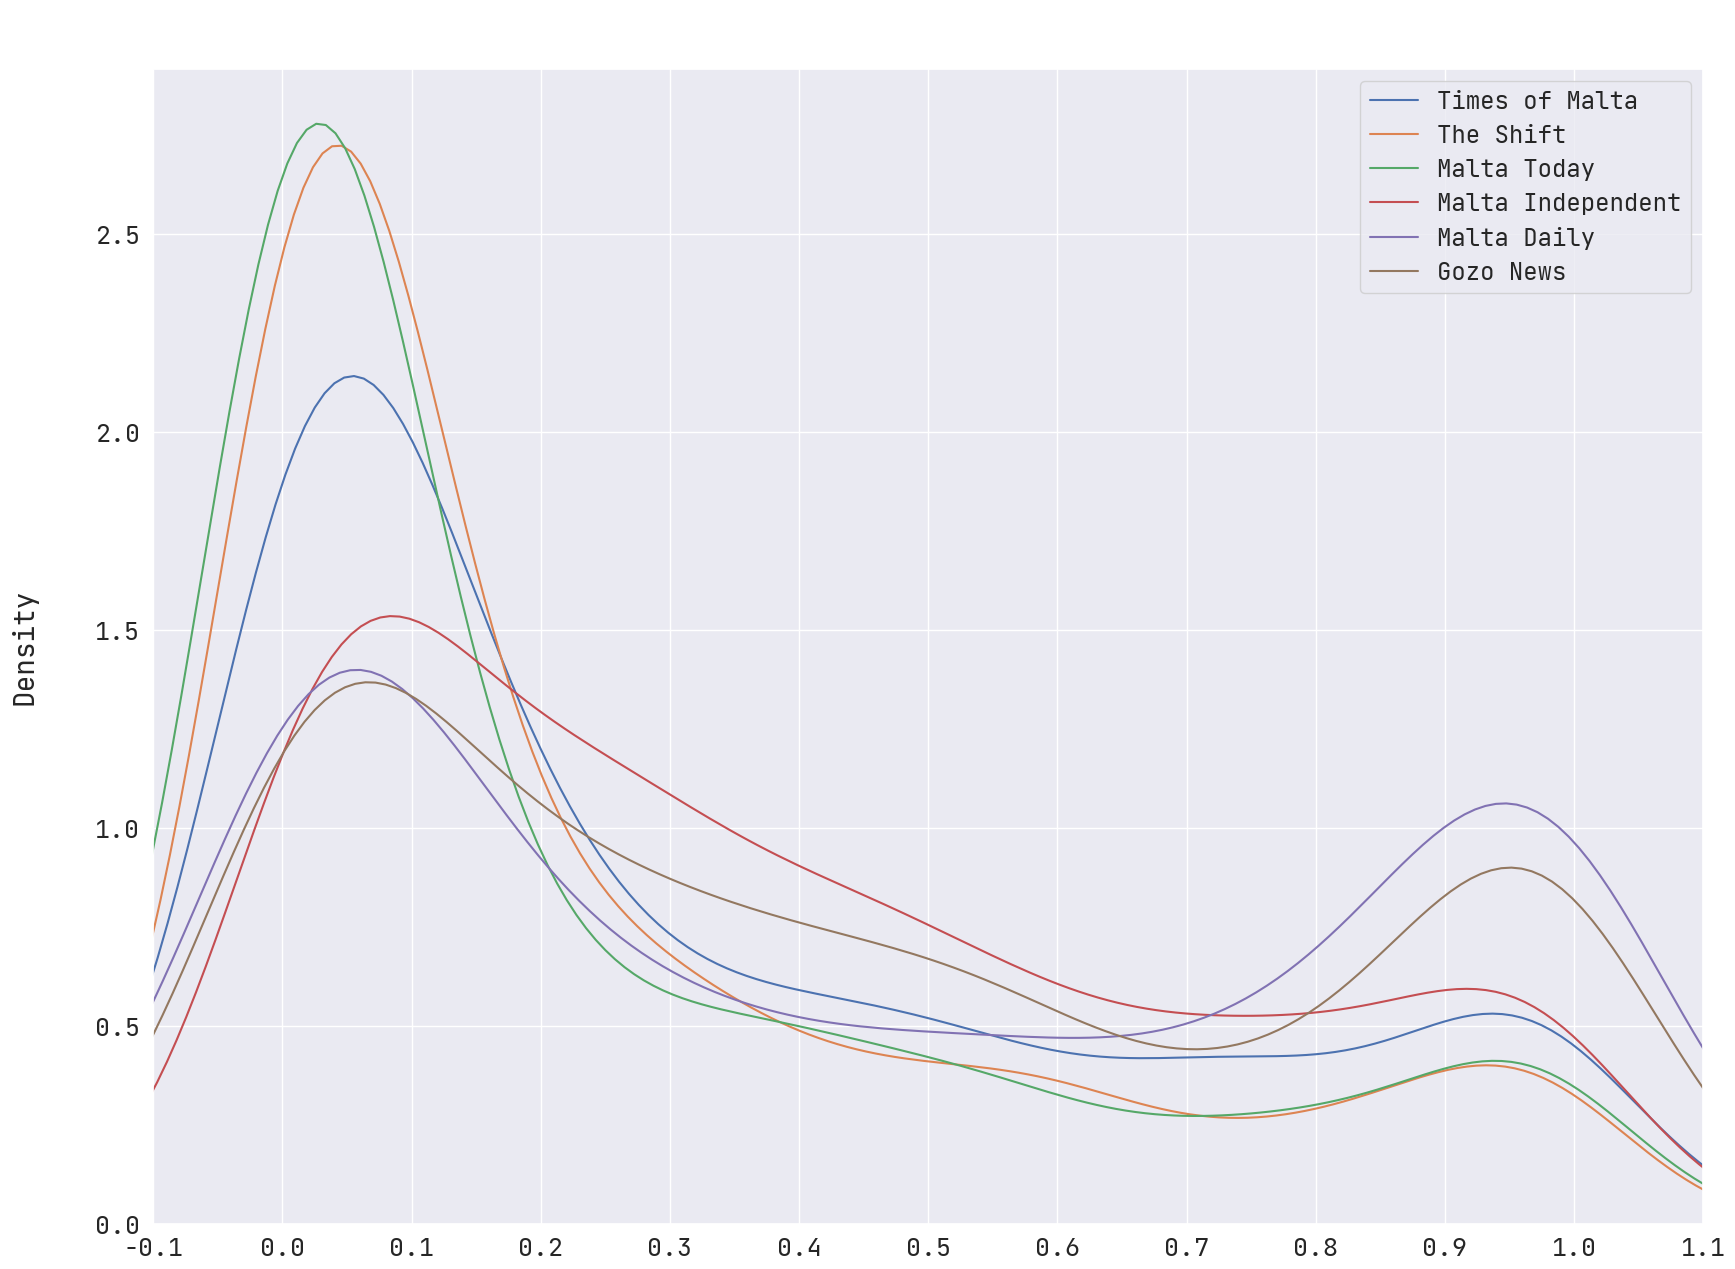

In [52]:
def draw_dist_overlay(key:str, xlabel:str,title:str):
    
    sns.set(rc={'figure.figsize':(20,15)})
    sns.set(font="JetBrains Mono")
    plt.clf()

    names = [['Times of Malta','The Shift'],
             ['Malta Today','Malta Independent'],
             ['Malta Daily','Gozo News']]
        
    for df in news_df:
        ax = sns.kdeplot(x=df[key])
        ax.tick_params(labelsize=18)
        ax.set_xlabel(f'\n{xlabel}', fontsize=20)
        ax.set_ylabel(f'Density', fontsize=20)
        ax.legend(np.array(names).flatten(),fontsize='x-large', title_fontsize='40')
        ax.set(xlim=(0,1))
        ax.yaxis.set_label_coords(-0.075,0.5)
        ax.set_title(f'\n{title}',fontsize=20)
        ax.set_xticks(np.arange(-0.1,1.1,0.1))
        
    pylab.savefig(os.path.join('figures','dist_overlay',f'{key} overlay_subplots.jpg'),
                      bbox_inches=None, pad_inches=0, dpi=300)
    
for key in hist_data:
    draw_dist_overlay(key,'','')
''

## 2 Feature correlations

''

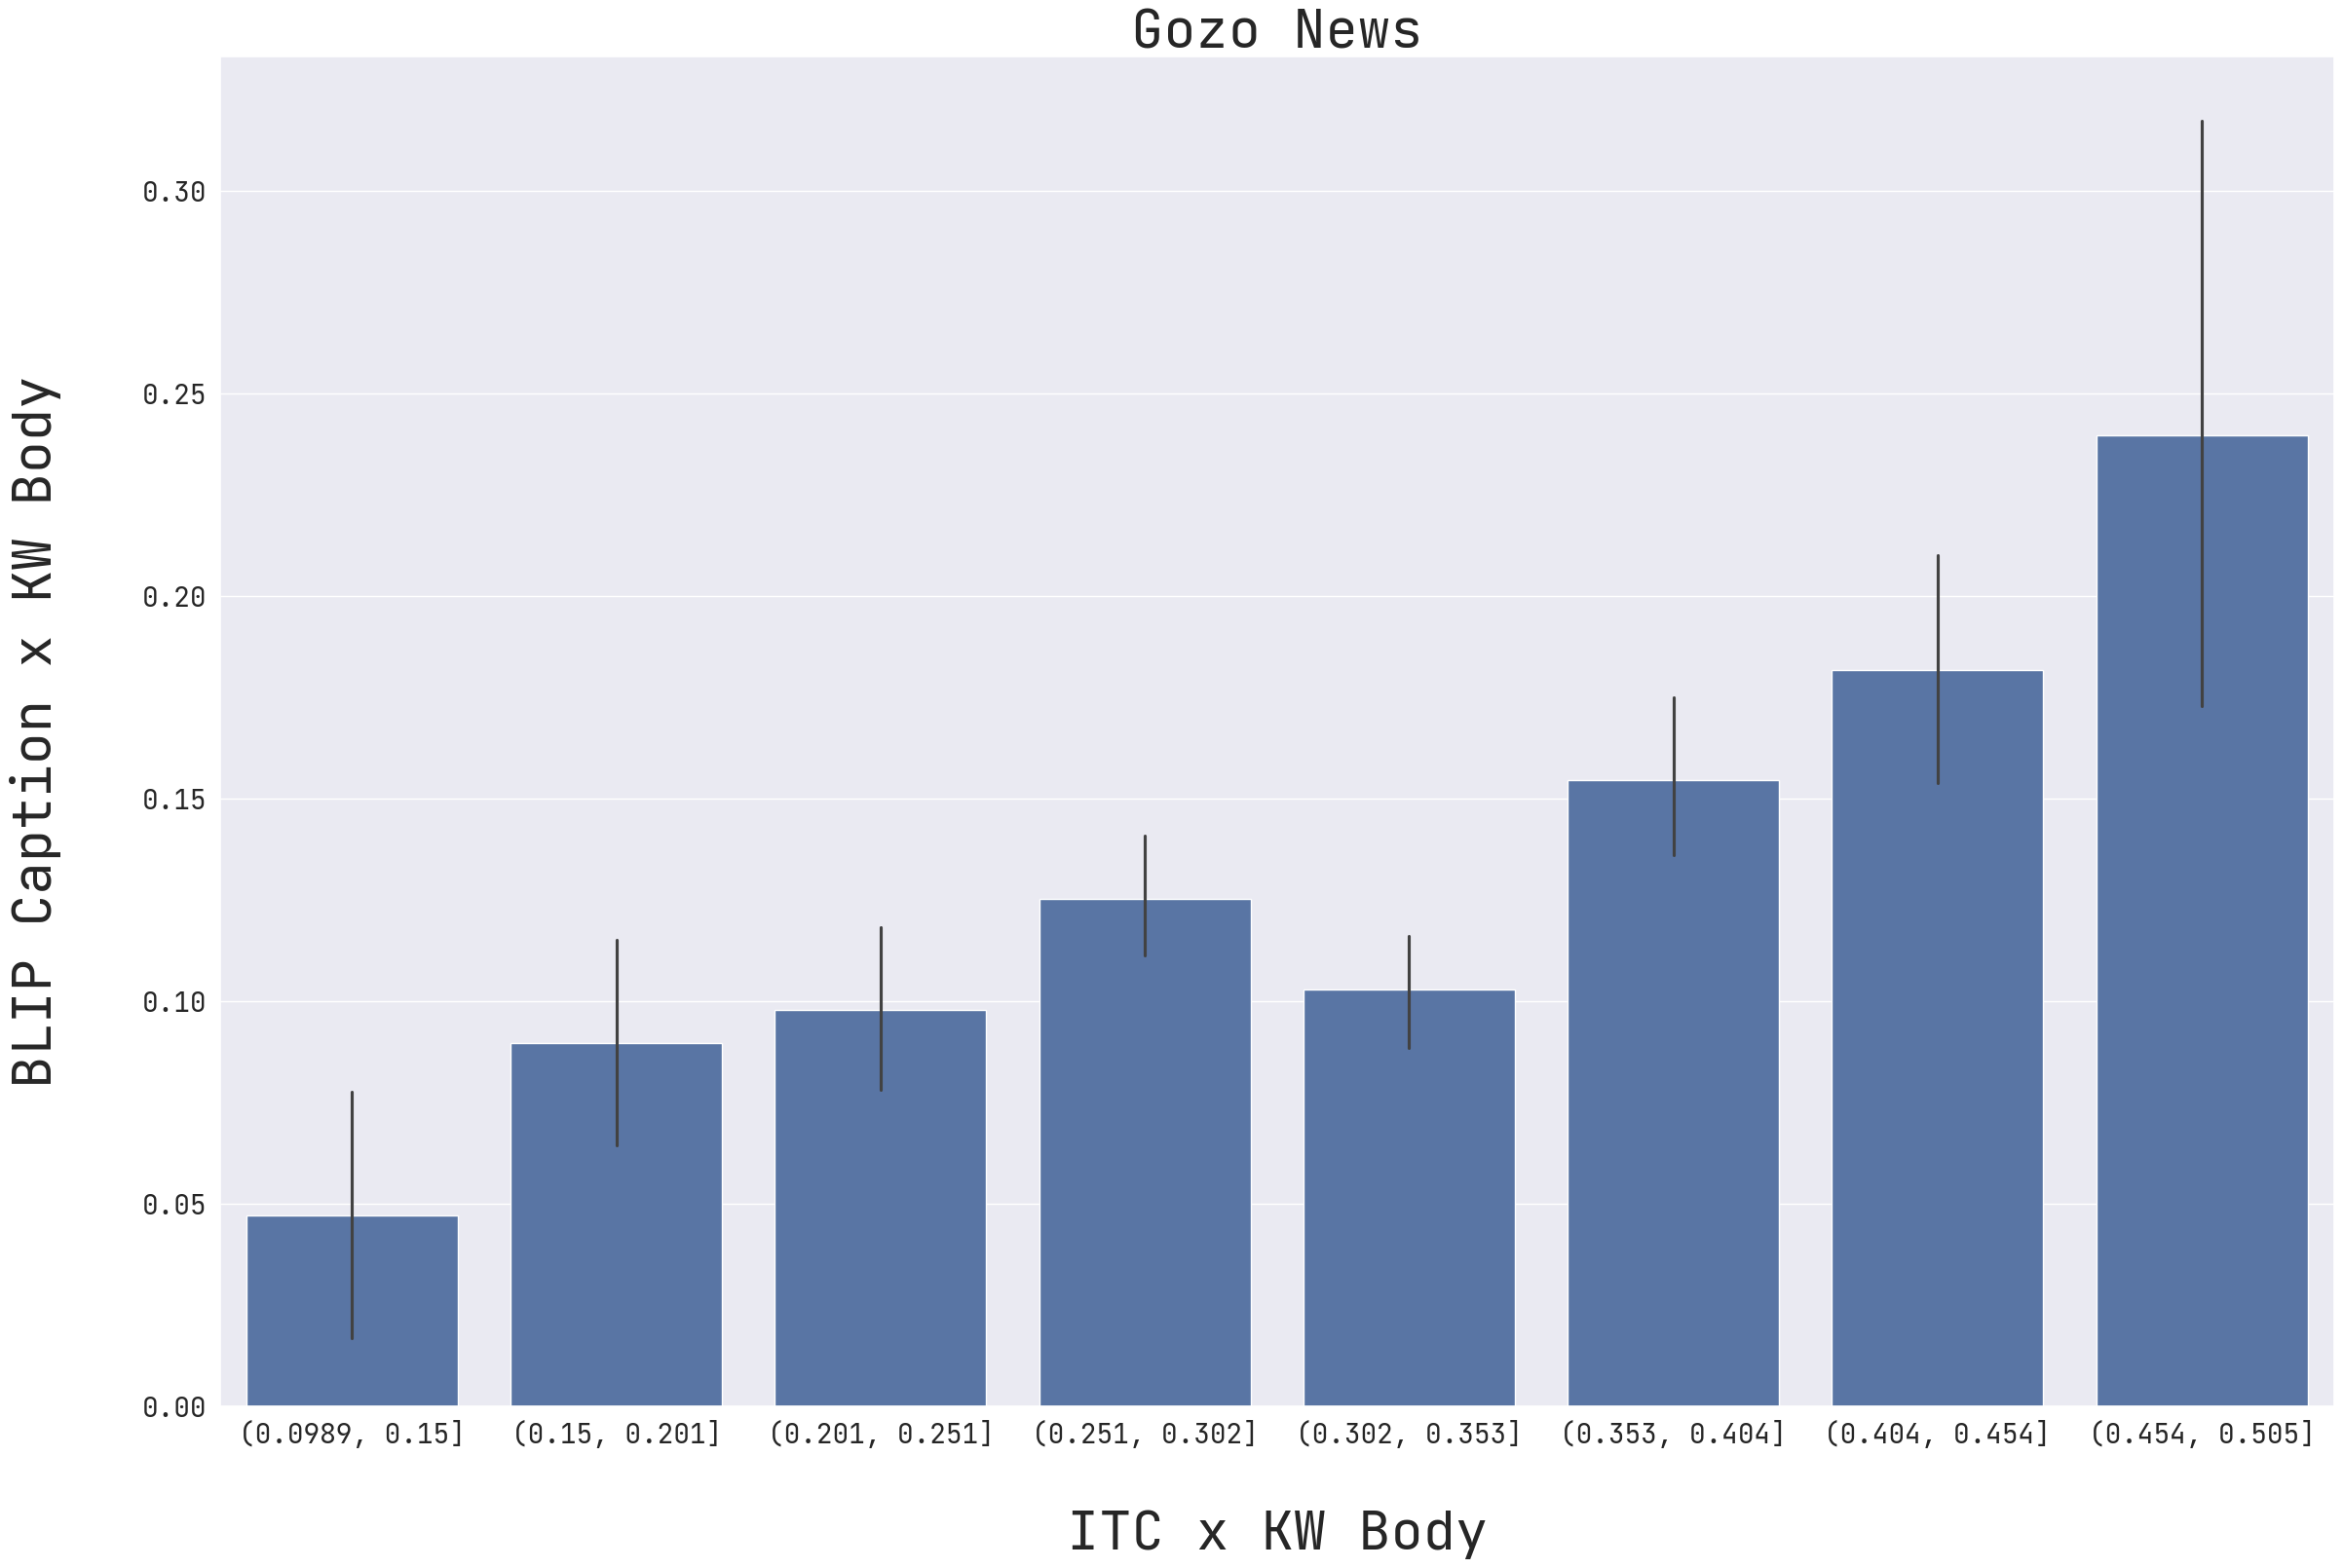

In [54]:
def draw_histlike(xkey:str,ykey:str,xlabel:str,ylabel:str,title:str):
    
    names = [['Times of Malta','The Shift'],
             ['Malta Today','Malta Independent'],
             ['Malta Daily','Gozo News']]
    
    for i,df in enumerate(news_df):    
        sns.set(rc={'figure.figsize':(28,18)})
        sns.set(font="JetBrains Mono")
        plt.clf()
        
        name = np.array(names).flatten()[i]
        
        try:
            df = df[df[xkey] != 0]
            df['group'] = pd.cut(df[key], 8)
        except: continue

        ax = sns.barplot(x=df['group'],y=df[ykey])
        ax.tick_params(labelsize=20)
        ax.yaxis.set_label_coords(-0.075,0.5)
        ax.set_xlabel(f'\n{xkey}', fontsize=40)
        ax.set_ylabel(f'{ylabel}', fontsize=40)
        ax.set_title(f'{name}', fontsize=40)
        
        pylab.savefig(os.path.join('figures','histlike',name,f'{xkey}-{ykey} histlike.jpg'),
                      bbox_inches=None, pad_inches=0, dpi=300)
    
    
for key,xlabel,title in bar_data:
    draw_histlike(xkey=key,ykey='ITM x KW Body',
                  xlabel=xlabel, ylabel='ITM x KW Body',
                  title=title)
    
    draw_histlike(xkey=key,ykey='BLIP Caption x KW Body',
                  xlabel=xlabel, ylabel='BLIP Caption x KW Body',
                  title=title)

''

In [56]:
def draw_scatter(xkey:str,ykey:str,xlabel:str,ylabel:str,title:str):
    
    sns.set(rc={'figure.figsize':(15,7)})
    sns.set(font="JetBrains Mono")
    
    
    names = [['Times of Malta','The Shift'],
             ['Malta Today','Malta Independent'],
             ['Malta Daily','Gozo News']]
    
    for i,df in enumerate(news_df):    
        df = df[df[xkey] != 0]
        
        c = round(df[xkey].corr(df[ykey]),2)
        name = np.array(names).flatten()[i]

        
        
        ax = sns.regplot(x=df[xkey],y=df[ykey])
        ax.tick_params(labelsize=12)
        ax.yaxis.set_label_coords(-0.075,0.5)
        ax.set_xlabel(f'{xkey}', fontsize=20)
        ax.set_ylabel(f'{ylabel}', fontsize=20)
        ax.set_title(f'\n{name} - corr={c}',fontsize=20)
        
        pylab.savefig(os.path.join('figures','scatter',name,f'{xkey}-{ykey} scatter.jpg'),
                      bbox_inches=None, pad_inches=0, dpi=300)
        plt.clf()
        
for key,xlabel,title in bar_data:
    draw_scatter(xkey=key,ykey='ITM x NER Title',
                  xlabel=xlabel, ylabel='ITM x NER Title',
                  title=title)
    
    draw_scatter(xkey=key,ykey='BLIP Caption x NER Title',
                  xlabel=xlabel, ylabel='BLIP Caption x NER Title',
                  title=title)

''

''

<Figure size 1500x700 with 0 Axes>

## Stacked Bar Chart

In [57]:
sns.set(rc={'figure.figsize':(12,5)})
sns.set(font="JetBrains Mono")

In [59]:
# newspapers = ['Times of Malta','The Shift','Malta Today',
#               'Malta Independent','Malta Daily','Gozo News']

# key = 'Title'

# neg = np.array(df[f'{key} s_Negative'])
# net = np.array(df[f'{key} s_Neutral'])
# pos = np.array(df[f'{key} s_Positive'])

# neg = neg[neg!=0]
# net = net[net!=0]
# pos = pos[pos!=0]


# actions = {'Positive': pos, 'Neutral': net, 'Negative': neg}

# fig, ax = plt.subplots()
# bottom = np.zeros(len(newspapers))

# for a, action in actions.items():
#     p = ax.bar(newspapers, action, label=a, bottom=bottom)
#     bottom += action
#     ac = [str(round(x*100,2))+'%' if x != 0 else '' for x in action]
#     ax.bar_label(p, labels=ac, label_type='center')

# ax.set_xlabel('Newspaper')
# ax.set_ylabel(f'Mean Sentiment in {key}')
# ax.set_xticks(range(len(newspapers)),newspapers,rotation='horizontal')
# ax.set_yticks(np.arange(0,1.1,0.1),range(0,110,10))
# ax.legend(['Positive','Neutral','Negative'],
#             bbox_to_anchor=(1.02,1.05))


# pylab.savefig(os.path.join('figures',f'{key} Sentiment Stacked.jpg'),
#                       bbox_inches='tight', pad_inches=0, dpi=300)
# plt.show()
# plt.clf()

## Summary Table Building

In [60]:
df['SCS'] = df.apply(lambda x: np.mean([i for i in [x['BLIP Caption x NER Title'],
                                                    x['BLIP Caption x NER Caption'],
                                                    x['BLIP Caption x KW Body']] if i]), axis=1)

df['ITM'] = df.apply(lambda x: np.mean([i for i in [x['ITM x NER Title'],
                                                    x['ITM x NER Caption'],
                                                    x['ITM x KW Body']] if i]), axis=1)

# df['pos'] = df.apply(lambda x: np.mean([i for i in [x['Title s_Positive'],
#                                                     x['Caption s_Positive'],
#                                                     x['Body s_Positive']] if i]), axis=1)

# df['net'] = df.apply(lambda x: np.mean([i for i in [x['Title s_Neutral'],
#                                                     x['Caption s_Neutral'],
#                                                     x['Body s_Neutral']] if i]), axis=1)
# df['neg'] = df.apply(lambda x: np.mean([i for i in [x['Title s_Negative'],
#                                                     x['Caption s_Negative'],
#                                                     x['Body s_Negative']] if i]), axis=1)



# df[['SCS','ITM','pos','net','neg']] = df[['SCS','ITM','pos','net','neg']].apply(lambda x: x.apply(lambda y: round(y*100,2)))
# df[['Newspaper','SCS','ITM','pos','net','neg']]

df[['SCS','ITM']] = df[['SCS','ITM']].apply(lambda x: x.apply(lambda y: round(y*100,2)))
df[['Newspaper','SCS','ITM']]


,Newspaper,SCS,ITM
0,Times of Malta,15.99,28.42
1,The Shift,8.79,20.44
2,Malta Today,10.90,19.51
3,Malta Independent,10.65,36.07
4,Malta Daily,14.27,42.04
5,Gozo News,13.68,39.34
